In [ ]:
import os, errno
import numpy as np
import pandas as pd
import h5py
from scipy.io import loadmat
from sklearn.utils import resample

# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn import metrics

# from dask.distributed import Client, LocalCluster

from matplotlib import pyplot as plt
from matplotlib.colors import Colormap, ListedColormap
from ipywidgets import interact, fixed
%matplotlib inline

from load import *
from comp import *
from plot import *

# from importlib import reload
# reload()

In [3]:
# Pick single dataset to look at
files = get_files(8)
print(files)

{'exp': '../Data/7737_291_000.exp', 'daq': '../Data/7737_291_000.bin', 'cfg': '../Data/7737_291_000.mat', 'roi': ['../Data/7737_291_000_catch.rois']}


In [12]:
# Gather filenames for whole dataset
f = get_dataset('S1 L2/3')
print(f['exp'])

['../Data/7142_220_002.exp', '../Data/6994_210_000.exp', '../Data/7120_250_003.exp']


In [111]:
# Load in stimulus times
info = loadmat(files['cfg'])
info["info"]
trigger_frame = info["info"]["frame"][0][0]
trigger_ID = info["info"]["event_id"][0][0]
if any(trigger_ID != 1): #spurious trigger on different channel
    trigger_frame = trigger_frame[trigger_ID==1]
print('# trials:', int(len(trigger_frame)/2))

# trials: 729


In [6]:
with h5py.File(files['exp'], 'r') as h5f:
    print(h5f['Experiment']['stim']['setup'][:])

[[3707764736          2          1          1          2          2]]


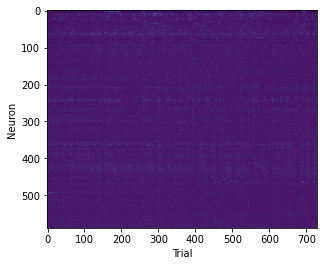

In [11]:
# Load in ROI responses
stim_dict, stim_ID, trial_index = load_experiment(files['exp'])
data = load_roi_trial_means(files['roi'])

plt.imshow(data)
plt.ylabel('Neuron')
plt.xlabel('Trial');

In [124]:
with h5py.File(files['roi'][0], "r") as h5f:
    print(list(h5f["ROIdata/rois/"].keys()))

['CI95', 'PValue', 'PValueCorrected', 'Raw', 'StdError', 'TunedPValue', 'centroid', 'color', 'curve', 'dFoF', 'data', 'depth', 'frame', 'label', 'mask', 'nTrials', 'neuropil', 'neuropilWeight', 'neuropilmask', 'pixels', 'position', 'rawdata', 'rawneuropil', 'stimMean', 'stimindex', 'tag', 'type', 'vertices']


In [33]:
dFoF = load_roi_data(files['roi'], 'dFoF')
dFoF.shape

(536, 17, 688)

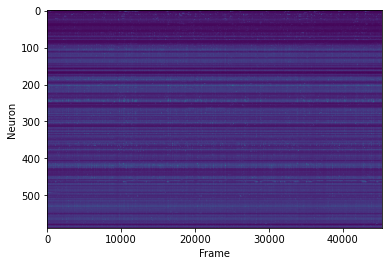

In [14]:
location = "rawdata"
data = load_roi_data(files['roi'], location=location)

plt.imshow(data, aspect='auto')
plt.ylabel('Neuron')
plt.xlabel('Frame');

In [18]:
centroids = load_roi_centroids(files['roi'])
print(np.shape(centroids))

(588, 2)


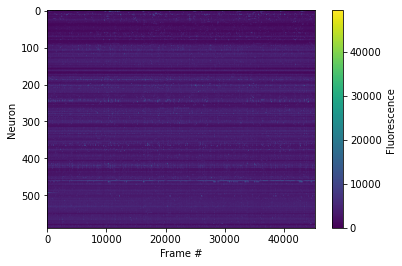

interactive(children=(IntSlider(value=0, description='index', max=587), Output()), _dom_classes=('widget-inter…

In [5]:
f, n = load_roi_traces(files['roi'])
coeff = compute_neuropil_coeff(f, n)
traces = correct_neuropil(f, n, coeff)

plt.imshow(traces, aspect="auto")
plt.ylabel("Neuron")
plt.xlabel("Frame #")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Fluorescence")

interact(trace, traces=fixed(traces), index=(0,np.size(traces,0)-1));

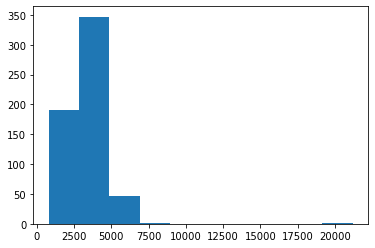

In [11]:
f, n = load_roi_traces(files['roi'])
coeff = compute_neuropil_coeff(f, n)
traces = correct_neuropil(f, n, coeff)

_, stim_id, _ = load_experiment(files['exp'])

trigger_frame, num_depths, frame_rate = load_config(files['cfg'])

num_frames = num_depths * np.size(traces,1) # off by less than 1 cycle but indices will be accurate for current depth
di = depth_indices(num_frames, num_depths, depth=0)

baseline = baseline_fluorescence(traces, stim_id, trigger_frame, round(frame_rate), di)
plt.hist(baseline);

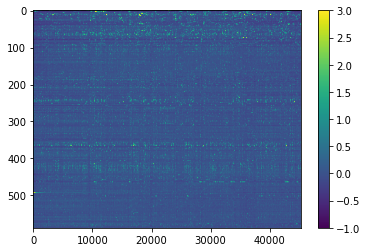

interactive(children=(IntSlider(value=0, description='index', max=587), Output()), _dom_classes=('widget-inter…

In [25]:
df = (traces-baseline)/baseline

plt.imshow(df, aspect='auto')
plt.clim([-1,3])
plt.colorbar();

interact(trace, traces=fixed(df), index=(0,np.size(df,0)-1));

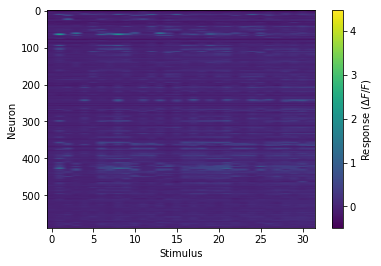

interactive(children=(IntSlider(value=0, description='index', max=587), Output()), _dom_classes=('widget-inter…

In [16]:
c, e = load_roi_tuning_curves(files['roi'])

# c_max = np.max(c,axis=1)
# c_norm = c/c_max[:,np.newaxis]
plt.imshow(c, aspect="auto")
plt.xlabel("Stimulus")
plt.ylabel("Neuron")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Response ($\Delta F/F$)")

interact(plot_tuning_curve, curves=fixed(c), ci=fixed(e), index=(0, np.size(c,0)-1));

In [26]:
class Experiment:
    def __init__(self, dataset_index=0, string="_catch"):
        self.files = get_dataset(dataset_index, string=string)
        self.fluorescence_traces = None
        self.tuning_curves = None
        self.linear_differences = None
        
    def load_experiment(self):
        self.stim_dict, self.stim_ID, self.trial_index = load_experiment(self.files['exp'])

In [29]:
# Trial align
# ind = 0
# exp_file, _, config_file, roi_files = get_dataset(ind)
trigger_frame, num_depths, frame_rate = load_config(config_file)
# stim_dict, stim_ID, trial_index = load_experiment(exp_file)
stim_start = trigger_frame[0::2]
n_before = round(16/num_depths)
n_after = round(31/num_depths)

ind = 0
f, neuropil = load_roi_traces([roi_files[ind]])
neuropil_coeff = compute_neuropil_coeff(f, neuropil)
traces = correct_neuropil(f, neuropil, neuropil_coeff)

depth_ID = depth_indices(np.size(traces, num_depths=4, depth=0)
    
trial_aligned = trial_align(traces, stim_start, depth_ID, n_before, n_after)
print(len(stim_start), len(trial_aligned), np.shape(trial_aligned[0]), stim_start[0])

NameError: name 'depth_ID' is not defined

In [ ]:
# Time avg
ind = 4
exp_file, _, config_file, roi_files = get_dataset(ind)
trigger_frame, num_depths, frame_rate = load_config(config_file)
stim_dict, stim_ID, trial_index = load_experiment(exp_file)
stim_start = trigger_frame[0::2]
n_before = round(16/num_depths)
n_after = round(31/num_depths)

f, neuropil = load_roi_traces(roi_files)
neuropil_coeff = compute_neuropil_coeff(f, neuropil)
traces = correct_neuropil(f, neuropil, neuropil_coeff)
trial_aligned = trial_align(traces, stim_start, depth_ID, n_before, n_after)
print(np.arange(n_before+1,n_before+round(16/num_depths)), np.shape(trial_aligned))

evoked_response = np.mean(trial_aligned[:, frame_index, :]).squeeze()
# response = time_avg(trial_aligned, frame_index=np.arange(n_before+1,n_before+round(16/num_depths)))
print(np.shape(evoked_response))

plt.imshow(response)

In [ ]:
# # load fluorescence and neuropil from each dataset and save to a .npz file
# for ind in range(10):
    
#     # Get dataset
#     exp_file, _, config_file, roi_files = get_dataset(ind)
#     trigger_frame, num_depths, frame_rate = load_config(config_file)
#     stim_dict, stim_ID, trial_index = load_experiment(exp_file)
#     stim_start = trigger_frame[0::2]
#     stim_end = trigger_frame[1::2]
#     n_before = round(16/num_depths)
#     n_after = round(31/num_depths)
    
#     for r, roi_file in enumerate(roi_files):

#         # load in traces and correct for neuropil
#         f, neuropil = load_roi_traces([roi_file])
#         neuropil_coeff = compute_neuropil_coeff(f, neuropil)
#         traces = correct_neuropil(f, neuropil, neuropil_coeff)

#         # trial-align traces
#         num_frames = np.ma.size(traces, axis=1)*num_depths
#         depth_ID = depth_indices(num_frames, num_depths, depth=r)
#         trial_aligned = trial_align(traces, stim_start, depth_ID, n_before, n_after)

#         # save to file
#         outfile = roi_file[:-11] + '.npz'
#         print(outfile)
#         np.savez(outfile, f=f, neuropil=neuropil, neuropil_coeff=neuropil_coeff, traces=traces, trial_aligned=trial_aligned,
#                  trial_index=trial_index, stim_dict=stim_dict, stim_ID=stim_ID, 
#                  stim_start=stim_start, stim_end=stim_end)

In [ ]:
# # load centroids from each dataset and save to a .npz file
# for ind in range(10):
    
#     # Get dataset
#     exp_file, _, config_file, roi_files = get_dataset(ind)
    
#     for r, roi_file in enumerate(roi_files):
        
#         # load roi centroids
#         centroids = load_roi_centroids([roi_file])

#         # save to file
#         outfile = roi_file[:-11] + '_centroids.npz'
#         print(outfile)
#         np.savez(outfile, centroids=centroids)

(1565,)


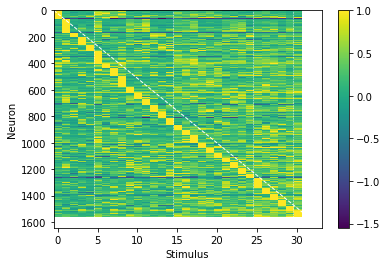

In [19]:
# Mean over all trials
f = get_dataset('S1 L2/3')
files = [f for l in f['roi'] for f in l]
curves, _ = load_roi_tuning_curves(files)

# _, stim_id, _ = load_experiment(files['exp'])
# trial_means = load_roi_trial_means(files['roi'])
# curves2, _ = compute_tuning_curve(tiral_means, stim_id)

curves = curves[np.any(curves>.2,1),:]
curves = curves[:,1:]
curves = curves / curves.max(1, keepdims=True)
tuning_curve_matrix(curves, sort=True, vertbars=[4.5,14.5,24.5,29.5])

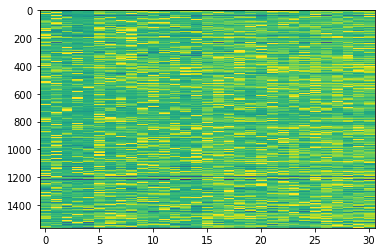

In [20]:
vertbars=[4.5,14.5,24.5,29.5]
plt.imshow(curves, aspect="auto", interpolation="none")
# plt.imshow(curves, interpolation="none", aspect="auto") #, extent=[-.5, np.size(curves,1)-.5, np.size(curves,0)-.5, -.5]
# plt.plot([-.5,np.size(curves,1)+.5], [-.5,np.size(curves,0)+.5], 'w--', linewidth=1)
# if vertbars:
#     if vertbars==True:
#         vertbars=[.5,5.5,15.5,25.5,30.5]
#         if np.size(curves,1)==31: # no catch
#             vertbars = vertbars[1:]-1
#         elif np.size(curves,1)==26: # multi-piston stimuli only
#             vertbars = vertbars[2:]-6
#     for v in vertbars:
#         plt.axvline(v, color='w', linestyle='--', linewidth=.5)
# plt.xlabel("Stimulus")
# plt.ylabel("Neuron")
# plt.colorbar()
# plt.clim(-1,1)
# plt.tight_layout(pad=7)
# plt.savefig('temp.png',dpi=300)

{'exp': '../Data/7737_291_000.exp', 'daq': '../Data/7737_291_000.bin', 'cfg': '../Data/7737_291_000.mat', 'roi': ['../Data/7737_291_000_catch.rois']}


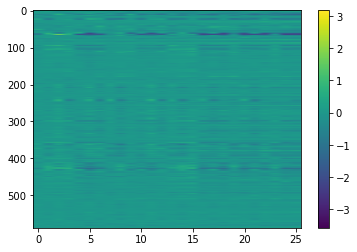

In [4]:
files = get_files(8)
print(files)
stim_dict, stim_id, _ = load_experiment(files['exp'])
trial_means = load_roi_trial_means(files['roi'])

ld, ci, a, s = compute_linear_difference(trial_means, stim_id, stim_dict, k=0)
plt.imshow(ld, aspect='auto')
plt.colorbar()

In [8]:
f = get_dataset('S1 L2/3')
stim = [load_experiment(file) for file in f['exp']]
stim_dict = [file[0] for file in stim]
stim_id   = [file[1] for file in stim]
trial_means = [load_roi_trial_means(file) for file in f['roi']]

curves, _, ld, _ = cv_sort(trial_means, stim_id, stim_dict, k=0)

(2328,)


(2328, 32) (2328, 26)


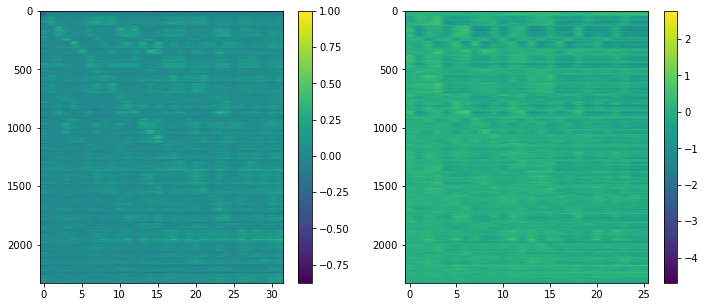

In [12]:
M = np.max(curves,1,keepdims=True)
curves = curves/M
ld = ld/M

fig, ax = plt.subplots(1, 2, figsize=(12,5))
img = ax[0].imshow(curves/np.max(curves,0,keepdims=True), aspect='auto')
plt.colorbar(img, ax=ax[0])
img = ax[1].imshow(ld, aspect='auto')
plt.colorbar(img, ax=ax[1])